In [38]:
from google.cloud import bigquery

bqclient = bigquery.Client.from_service_account_json("musa-509-75492c1cf2ae.json")

In [39]:
import pandas as pd
import geopandas as gpd
import datashader as ds
import numpy as np

import datashader.transfer_functions as tf
import matplotlib.pyplot as plt

from datashader.bundling import connect_edges, hammer_bundle
from datashader.colors import inferno, viridis
from datashader.utils import export_image
from datashader.utils import lnglat_to_meters

from colorcet import palette
from matplotlib import cm

import cenpy
import imageio

acs = cenpy.remote.APIConnection("ACSDT5Y2018")
acs.set_mapservice("tigerWMS_ACS2018")

Connection to American Community Survey: 1-Year Estimates: Detailed Tables 5-Year(ID: https://api.census.gov/data/id/ACSDT5Y2018)
With MapServer: Census Current (2018) WMS

In [40]:
def get_pois(city, state):
    
    query = f"""
        SELECT longitude, latitude
        FROM `tidal-digit-291220.safegraph.places`
        WHERE city = '{city}' AND region = '{state}'
            """
    
    q = bqclient.query(query)
    r = q.result()
    d = r.to_dataframe()
    
    X, Y = lnglat_to_meters(d['longitude'], d['latitude'])

    d['X'] = X
    d['Y'] = Y
    
    return(d)

In [41]:
nyc = get_pois("New York", "NY")

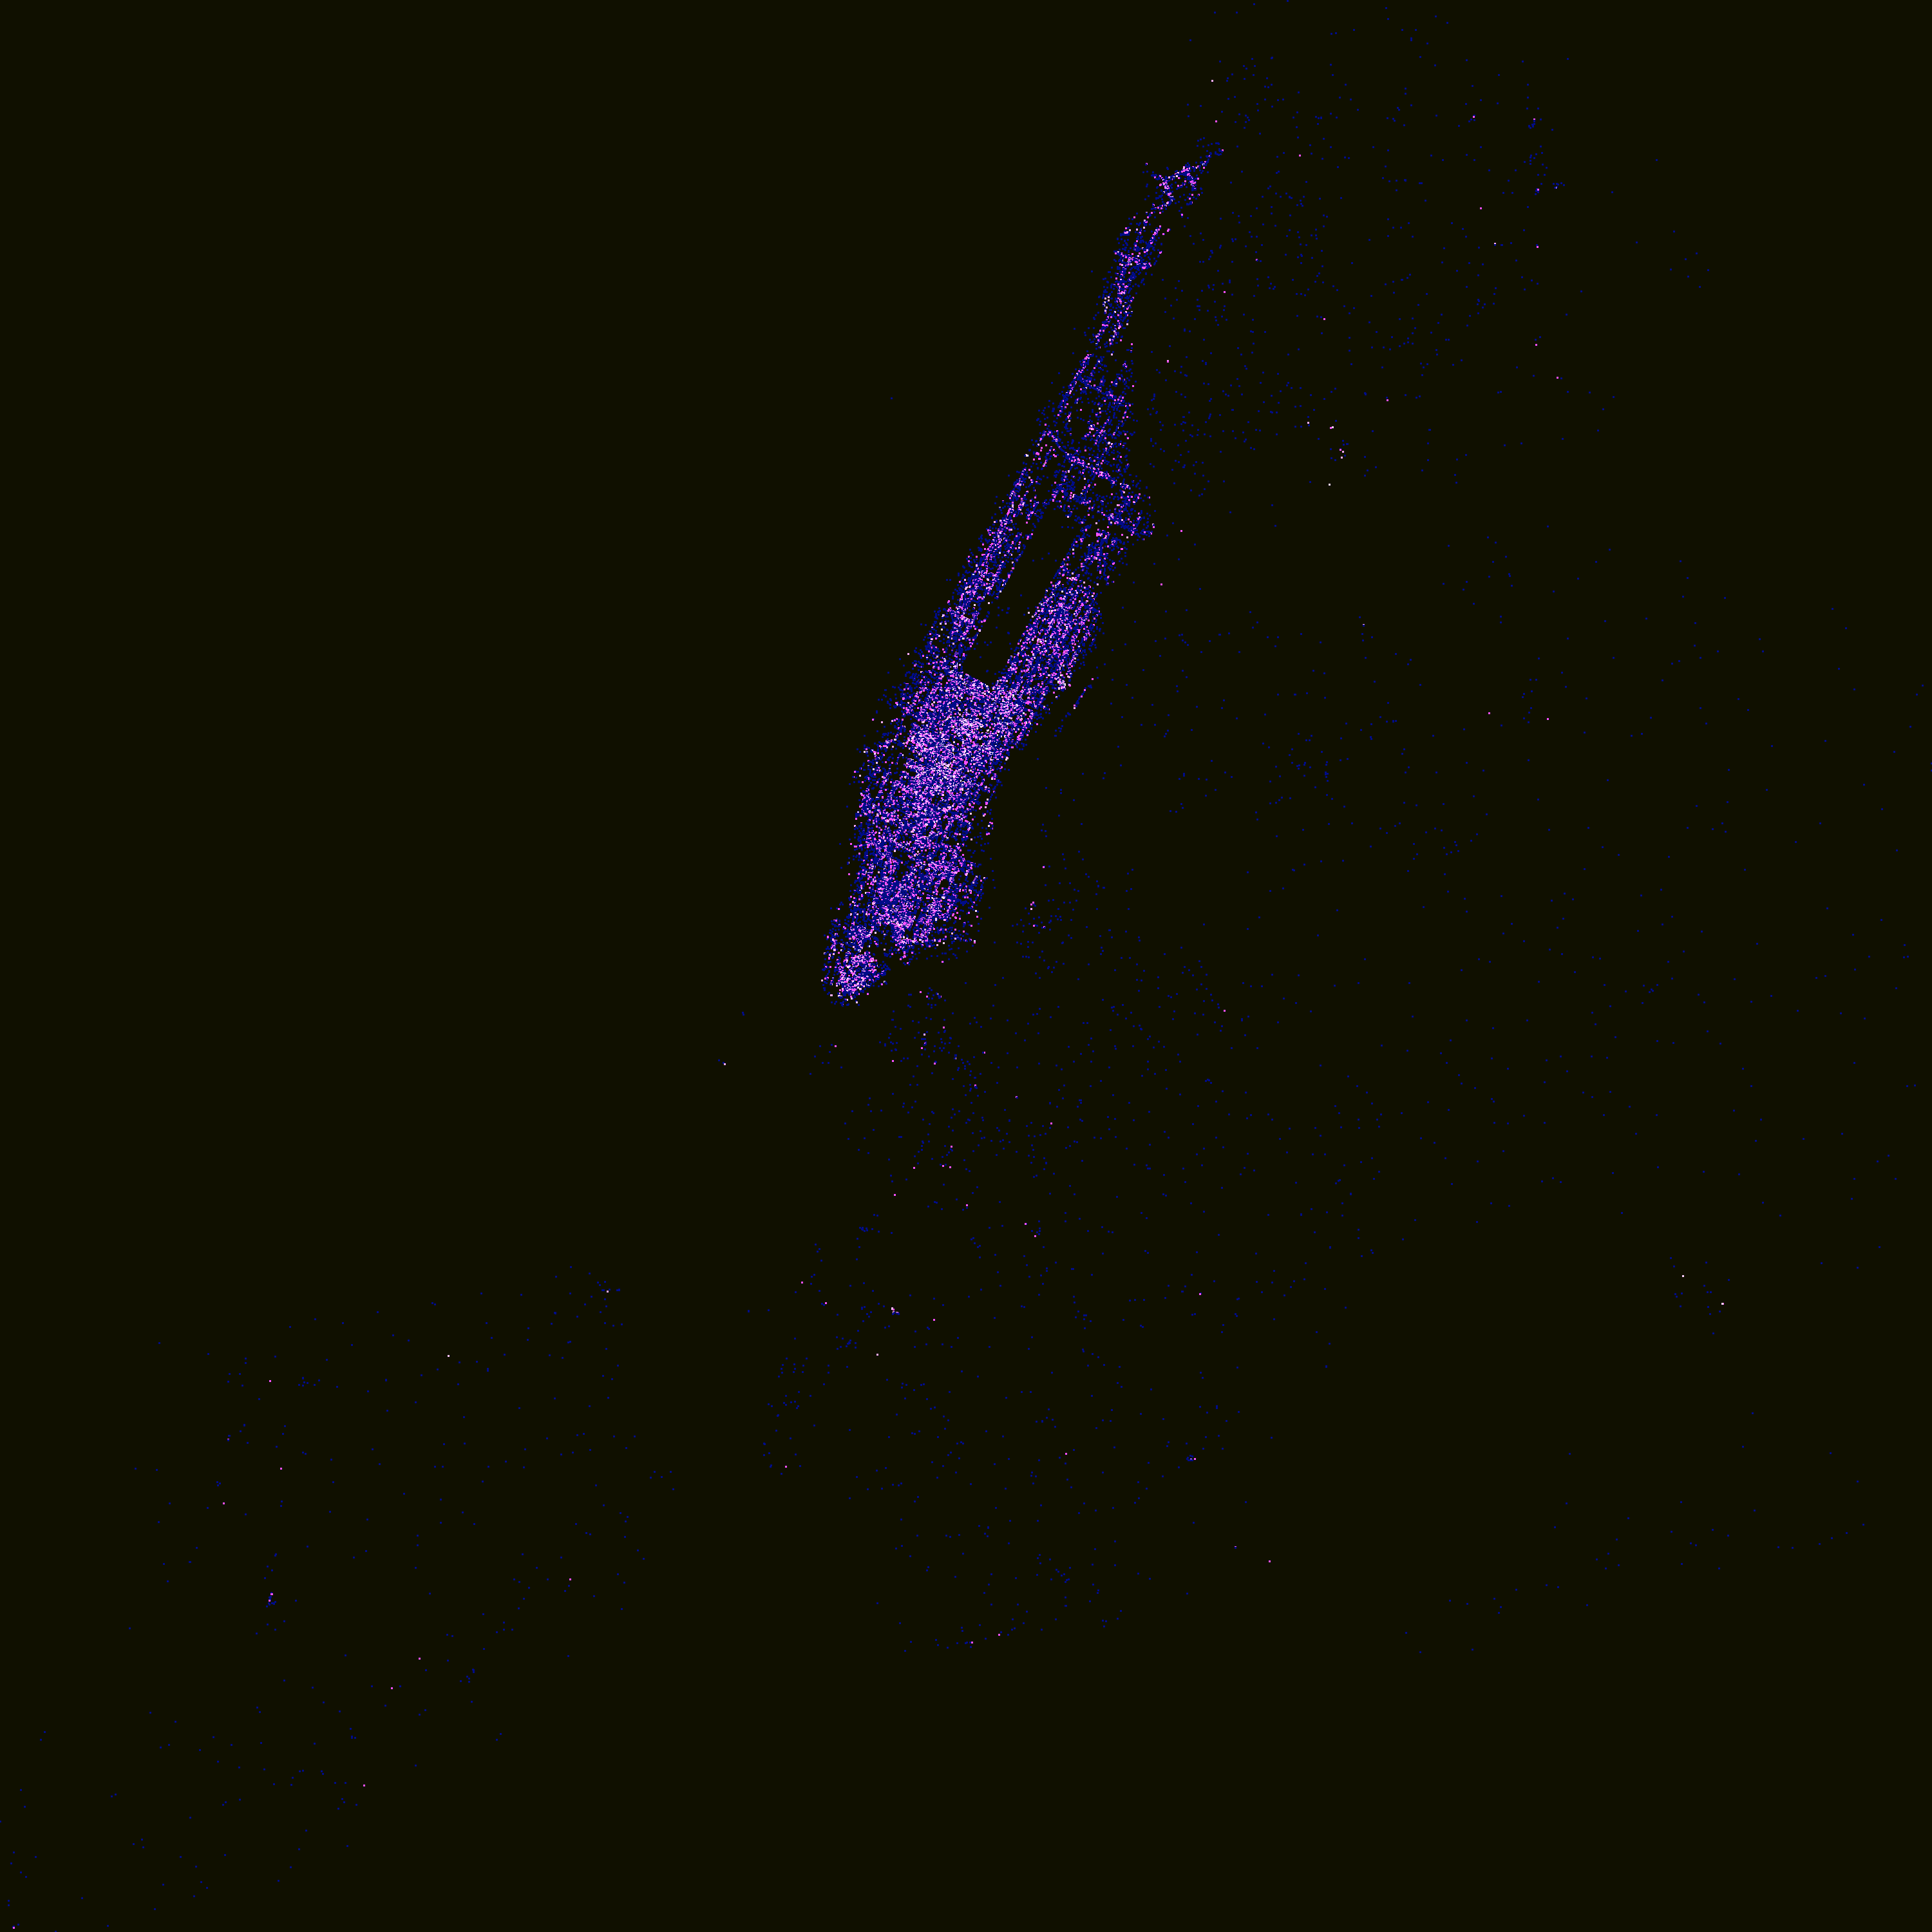

In [42]:
nyc['outlier_x'] = pd.qcut(nyc.X, 100, labels=False)
nyc['outlier_y'] = pd.qcut(nyc.Y, 100, labels=False)

for i in np.arange(1, 10):
    nyc = nyc[(nyc['X']!=nyc['X'].min()) & (nyc['Y']!=nyc['Y'].min())]
    nyc = nyc[(nyc['X']!=nyc['X'].max()) & (nyc['Y']!=nyc['Y'].max())]

range_x = (nyc['X'].min(), nyc['X'].max())
range_y = (nyc['Y'].min(), nyc['Y'].max())

wi = int(3000)
hi = int(3000)

cvs = ds.Canvas(plot_width=wi, plot_height=hi, x_range=range_x, y_range=range_y)
agg = cvs.points(nyc, "X", "Y", agg=ds.count())

img = tf.shade(agg, cmap=palette['bmw'][20:], how="eq_hist")
img = tf.spread(img, px=1, how='saturate')
img = tf.set_background(img, "#101000")

img

In [43]:
chi = get_pois("Chicago", "IL")

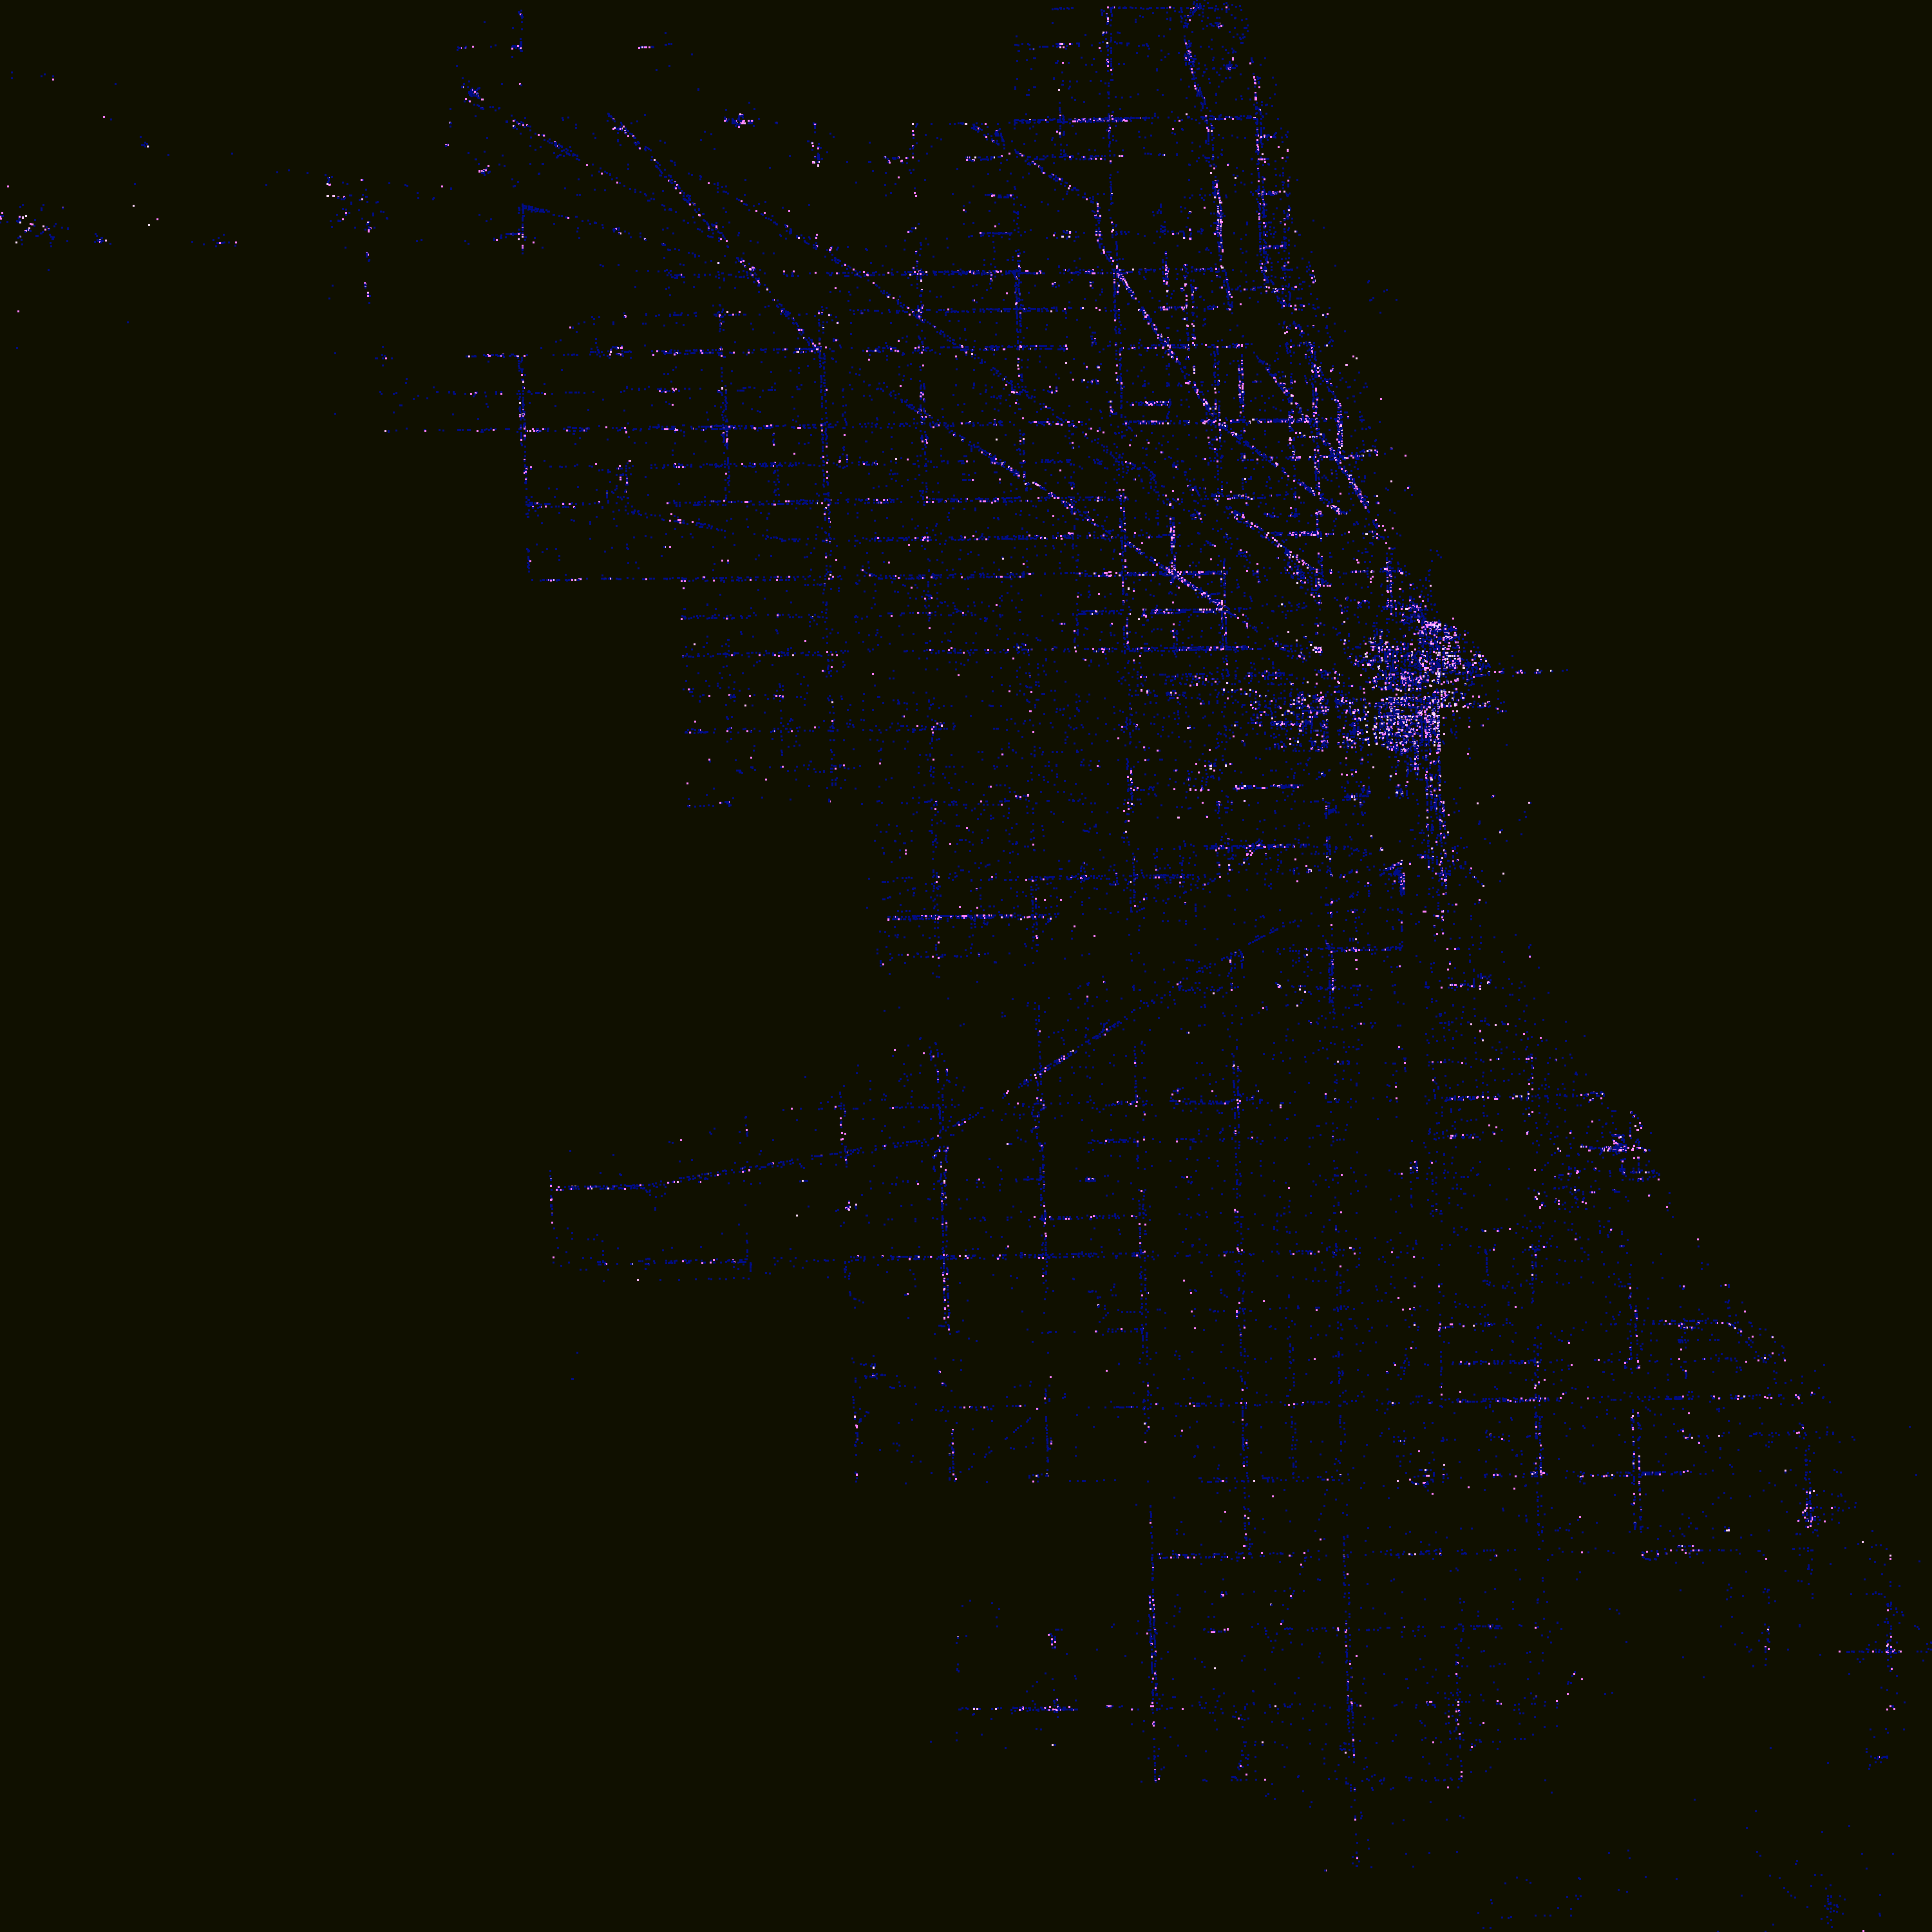

In [44]:
chi['outlier_x'] = pd.qcut(chi.X, 100, labels=False)
chi['outlier_y'] = pd.qcut(chi.Y, 100, labels=False)

for i in np.arange(1, 10):
    chi = chi[(chi['X']!=chi['X'].min()) & (chi['Y']!=chi['Y'].min())]
    chi = chi[(chi['X']!=chi['X'].max()) & (chi['Y']!=chi['Y'].max())]

range_x = (chi['X'].min(), chi['X'].max())
range_y = (chi['Y'].min(), chi['Y'].max())

wi = int(3000)
hi = int(3000)

cvs = ds.Canvas(plot_width=wi, plot_height=hi, x_range=range_x, y_range=range_y)
agg = cvs.points(chi, "X", "Y", agg=ds.count())

img = tf.shade(agg, cmap=palette['bmw'][20:], how="eq_hist")
img = tf.spread(img, px=1, how='saturate')
img = tf.set_background(img, "#101000")

img

In [52]:
def get_nodes(fips):
    
    state = fips[:2]
    county = fips[2:]
        
    where_clause = f"STATE = {state} AND COUNTY = {county}"
    block_groups = acs.mapservice.layers[10].query(where=where_clause)
    
    block_groups = block_groups.to_crs(3857)
    
    nodes = pd.DataFrame({'X': block_groups.centroid.x,
                          'Y': block_groups.centroid.y,
                          'cbg': block_groups.GEOID.astype('int64')}).set_index('cbg')
    
    return nodes

In [46]:
def get_edges(fips, month, cbgs):
    
    job_config = bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("fips", "STRING", fips),
            bigquery.ScalarQueryParameter("month", "STRING", month),
        ]
    )
    
    query = f"""
        SELECT poi_cbg, home_cbg, sum(visits) as visits
        FROM (SELECT 
                lpad(CAST(poi_cbg AS STRING), 12, '0') as poi_cbg, 
                REGEXP_EXTRACT(unnested, '(.*?):') as home_cbg, 
                CAST(REGEXP_EXTRACT(unnested, ':(.*)') AS NUMERIC) as visits
              FROM `tidal-digit-291220.safegraph.2020_{month}`
              CROSS JOIN UNNEST(SPLIT(regexp_replace(REPLACE(REPLACE(visitor_home_cbgs, '{{', ''), '}}', ''), '\\"', ''))) as unnested
              WHERE SUBSTR(lpad(CAST(poi_cbg AS STRING), 12, '0'), 0, 5) = @fips AND visitor_home_cbgs != '{{}}')
        GROUP BY poi_cbg, home_cbg
            """
    
    resp = bqclient.query(query, job_config=job_config)
    data = resp.to_dataframe()
    
    edges = data.rename(columns={'poi_cbg': 'focal', 
                                 'home_cbg': 'target', 
                                 'visits': 'weight'})

    edges['focal'] = edges['focal'].astype('int64')
    edges['target'] = edges['target'].astype('int64')
    edges['weight'] = edges['weight'].astype('int64')

    edges = edges[edges['target'].isin(cbgs)]
    edges = edges[edges['weight']>10]
    
    return edges

In [47]:
def get_graph(edges, nodes, method='direct'):
    if method == 'bundled':
        print('Bundling desire lines...')
        return hammer_bundle(nodes, edges,
                             source='focal', target='target',
                             decay=0.25,
                             x='X', y='Y')
    else:
        print('Linking desire lines...')
        return connect_edges(nodes, edges,
                             source='focal', target='target',
                             x='X', y='Y')

In [48]:
def composers(graph, nodes):
    canvas = ds.Canvas(x_range=(nodes['X'].min(), nodes['X'].max()),
                       y_range=(nodes['Y'].min(), nodes['Y'].max()),
                       plot_height=3000, plot_width=3000)


    agg = tf.shade(canvas.line(graph, 'X', 'Y', agg=ds.count()),  cmap=palette['bmw'], how='eq_hist')
    img = tf.set_background(agg, "#000000")
    
    return img

In [49]:
nodes = get_nodes('42101')

nodes.head()

/Users/andrewrenninger/anaconda3/envs/sandbox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


X             Y
cbg                                     
421010355002 -8.352385e+06  4.878351e+06
421010355003 -8.352319e+06  4.879380e+06
421010356011 -8.353301e+06  4.879494e+06
421010356022 -8.353846e+06  4.881514e+06
421010386001 -8.372377e+06  4.874381e+06

In [53]:
edges = get_edges('42101', '04', nodes.reset_index()['cbg'])

edges.head()

focal        target  weight
1   421010212001  421010213004      16
2   421010212001  421010212001      65
3   421010214001  421010215002      13
8   421010214001  421010214004      15
10  421010007002  421010012021      12

Linking desire lines...
Bundling desire lines...



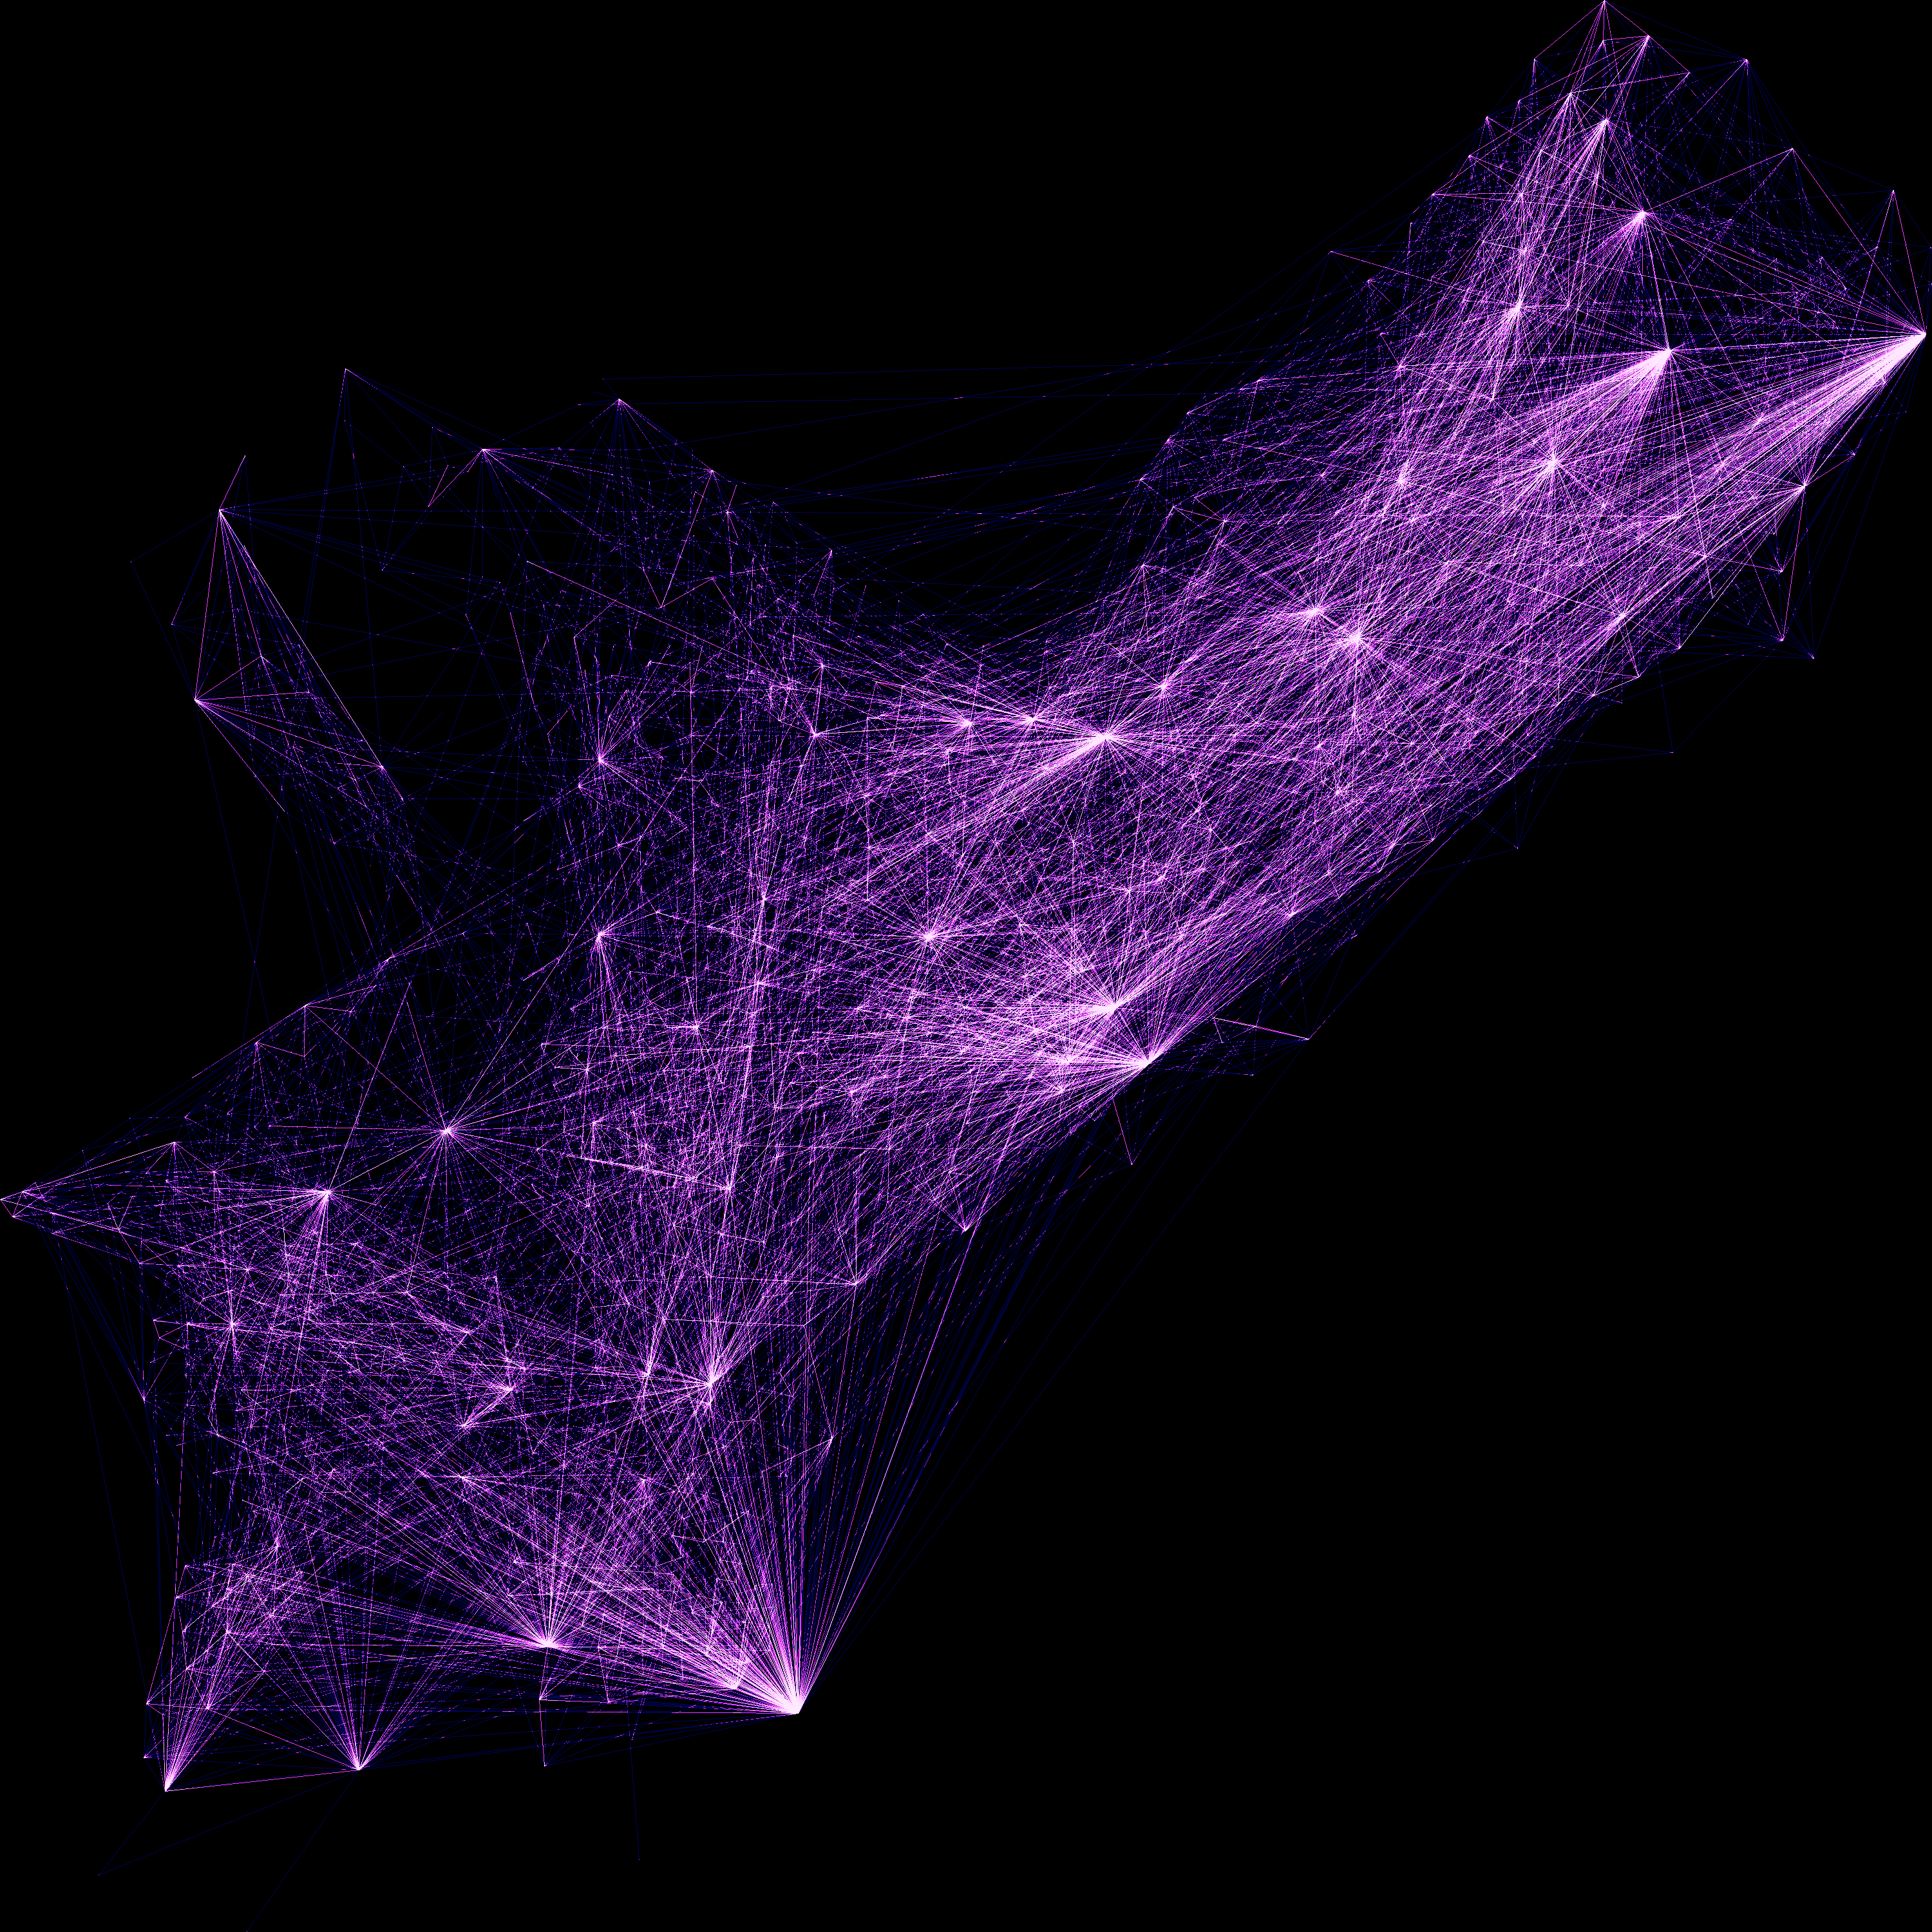
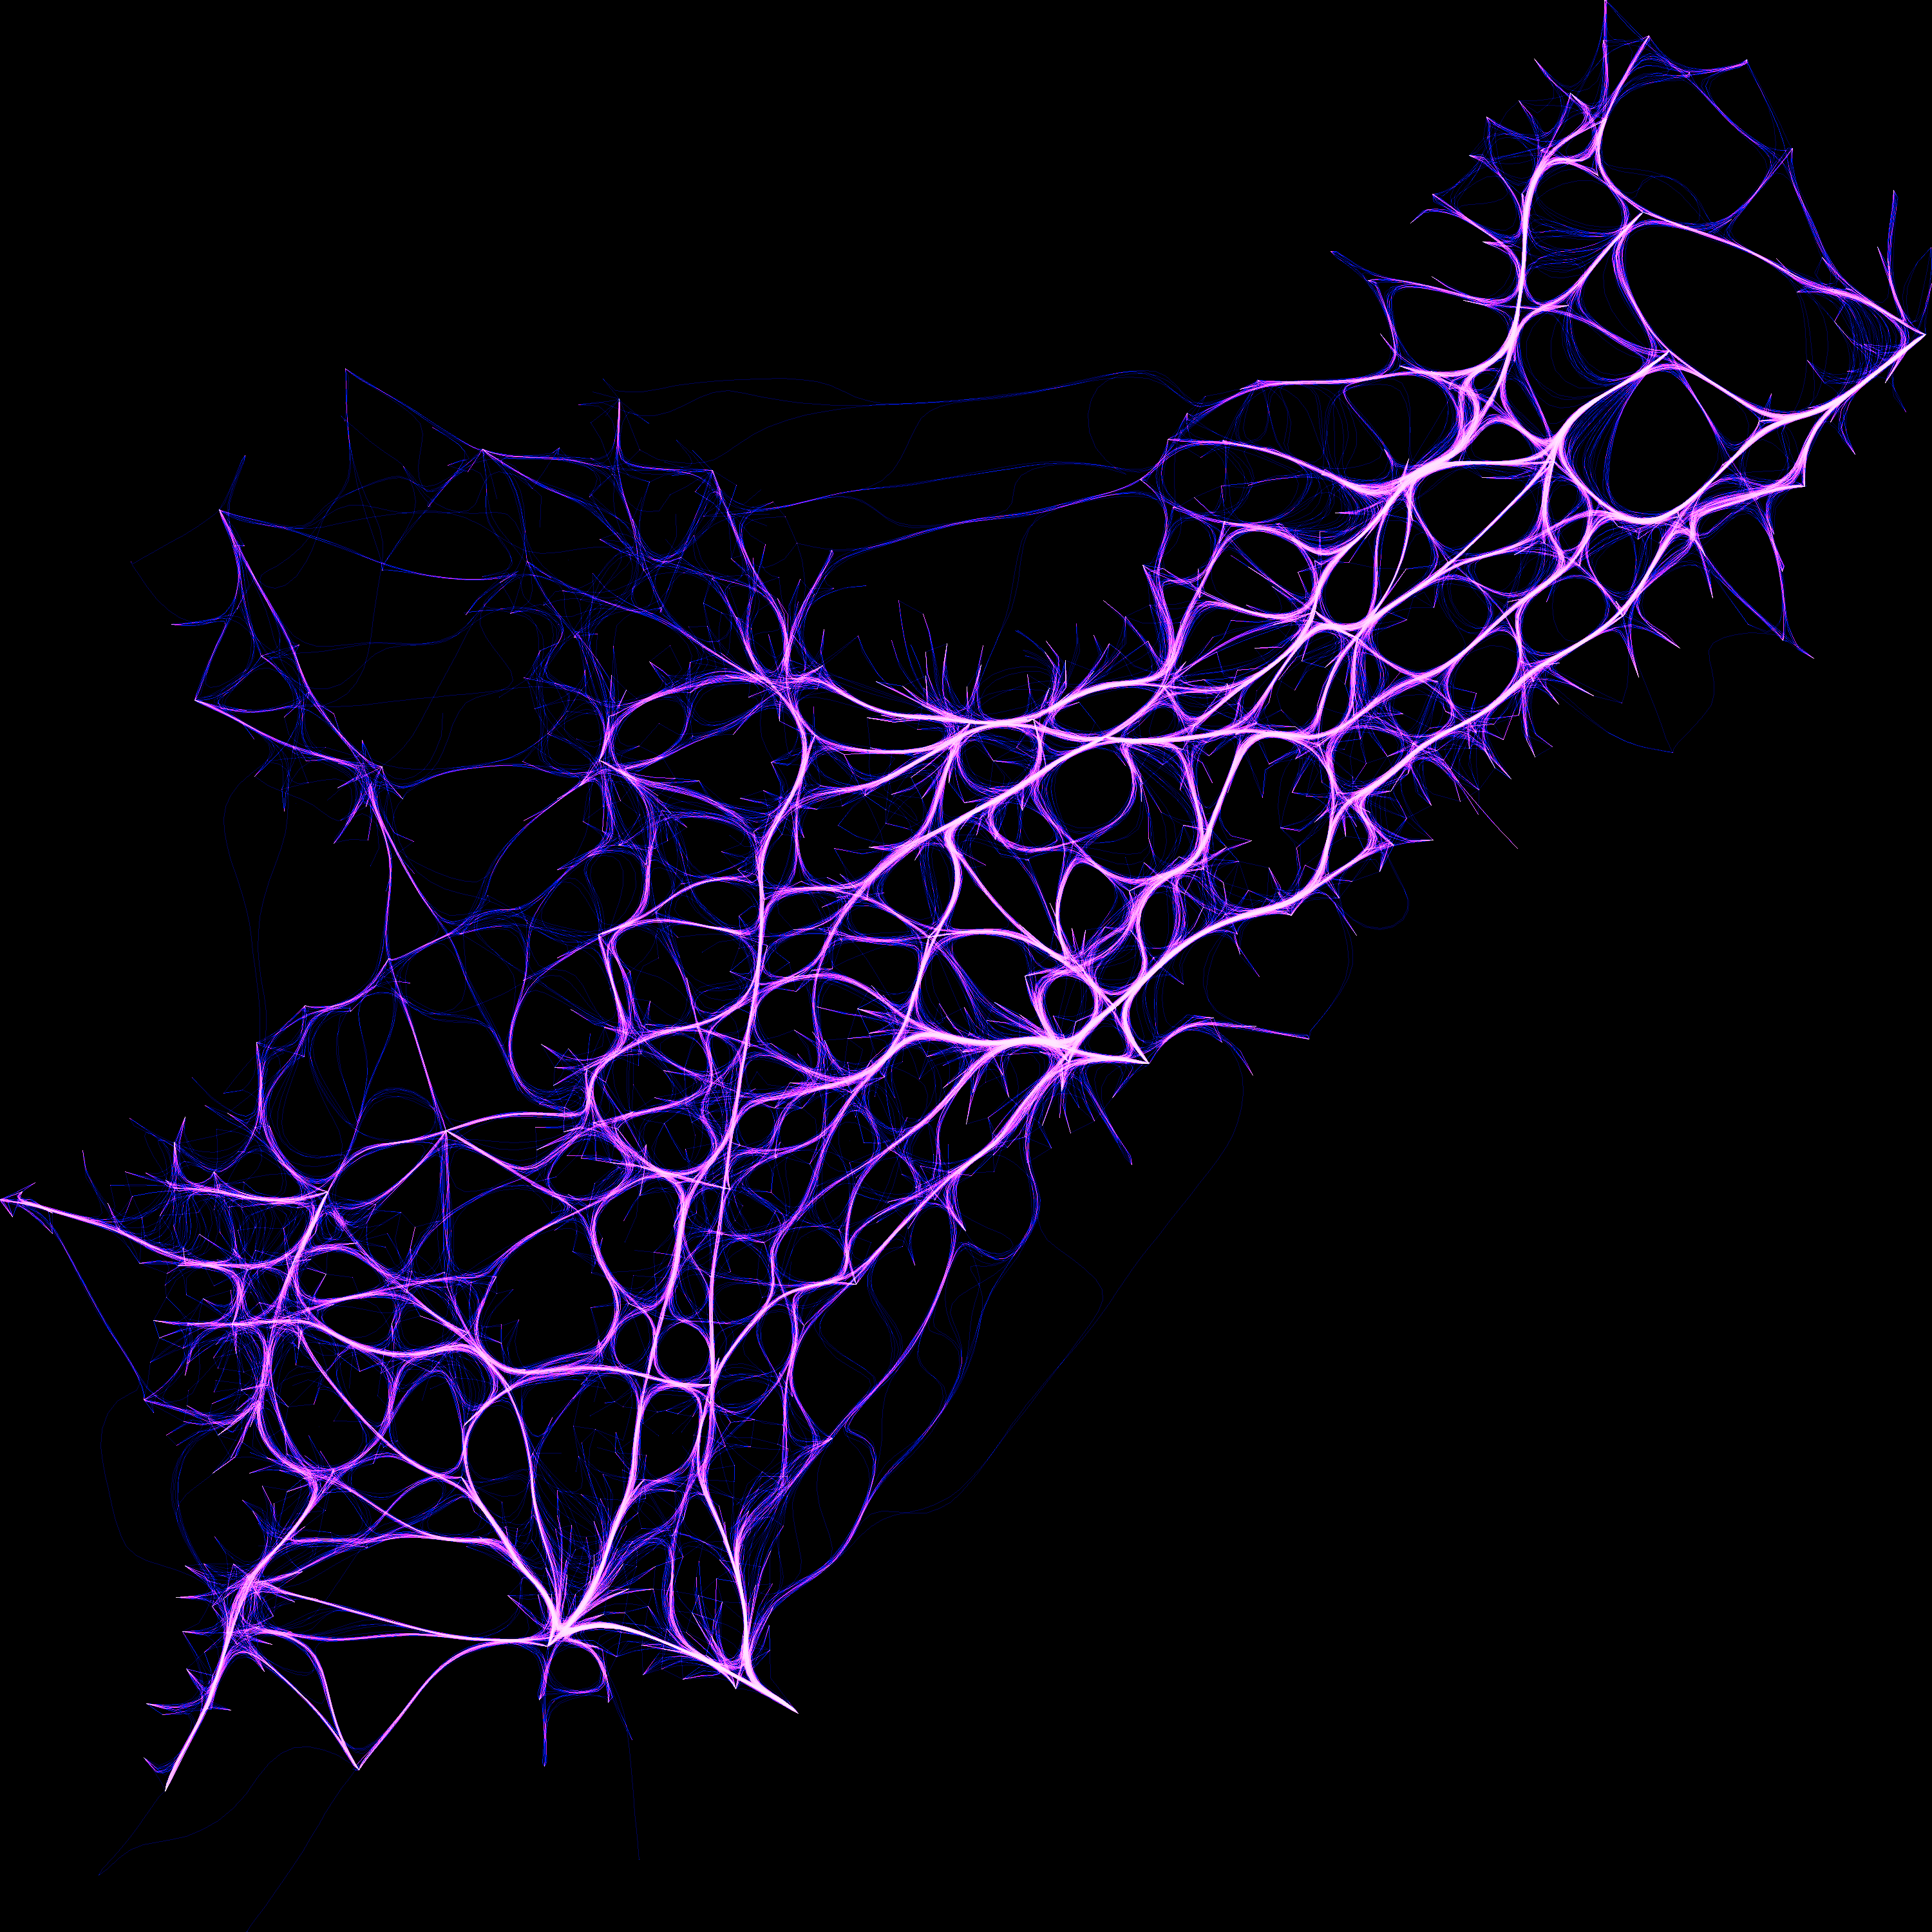

In [54]:
tf.Images(composers(get_graph(edges, nodes, method='direct'), nodes), 
          composers(get_graph(edges, nodes, method='bundled'), nodes)).cols(2)